## Import libs and custom vars

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from libs.utils import find_penalty, return_outcome, check_element, add_labels
from matplotlib import pyplot as plt
import datetime
from numba import jit

<ul>
    <li>Ci sono alcuni nomi di squadre che sono cambiate nel tempo, uniformizza </li>
    <li>Shootouts è il db dei penalty, quindi bisogna manipolare il dataset per vedere chi vince alla fine quella partita</li>
</ul>

## Descrizione del dataset e preprocessing

Il Dataset contiene 42483 risultati di partite di calcio internazionale,

Il primo match risale al 1872-11-30 mentre l’ultimo è del 2021-08-01

Nel dataset sono incluse sia le partite ufficiali di tutte le competizioni, dalle amichevoli alla coppa del mondo. è da specificare inoltre che comprende solo le competizioni nazionali maschili e sono esclusi: Olympic Games or matches where at least one of the teams was the nation's B-team, U-23 or a league select team.

Inoltre, il dataset presenta un ulteriore file che contiene, in totale 432 risultati finali di partite terminate ai calci di rigore (vincenti).

Per correttezza, controlleremo inizialmente che il Dataset non contenga elementi nulli e i due dataset verranno inoltre ‘mergiate’ in un unico file contenti i risultati, dove presenti, anche dopo i calci di rigore.

In [57]:
data = {
    'results': pd.read_csv('dataset/results.csv'),
    'shootouts': pd.read_csv('dataset/shootouts.csv')
}

# print('**'*5, ' results.csv ', '**'*5)
# print(data['results'].info())
# print('**'*5, ' shootouts.csv ', '**'*5)
# print(data['shootouts'].info())

Il dataset non contiene elementi nulli. Visualizziamo le prime 5 righe di ogni dataset

In [ ]:
print('**'*5, ' results.csv ', '**'*5)
print(data['results'].head(5))
print('**'*5, ' shootouts.csv ', '**'*5)
print(data['shootouts'].head(5))

Applichiamo dunque alcune modifiche al dataset. Si integrano di conseguenza alcune informazioni del dataset 'shootouts'

In particolare, processeremo il dataset (partendo da quello di results.csv):
- aggiungendo la colonna 'outcome', sarà classificato come:
    - H (home win)
    - A (away win)
    - D (draw), in particolare se in 'shootouts' è presente la partita 'draw':
        - HP (home win at penalty)
        - AP (away win at penalty)

- saranno estratti i dati relativi alla data della partita in quanto serviranno successivamente

In [ ]:
dst_df = data['results'].copy()

res_len = data['results'].__len__()
sht_len = data['shootouts'].__len__()

print('results.csv tot records: %d | shape: %s' % (res_len, data['results'].shape))
print('shootouts.csv tot records: %d | shape: %s' % (sht_len, data['shootouts'].shape))

In [ ]:
# aggiungi una colonna al dataFrame che aggiorna con i risultati dei rigori

dst_df['outcome'] = None
dst_df['day_of_week'] = None
dst_df['month'] = None
dst_df['year'] = None

counter = 0
for i in range(0, res_len):
    counter = counter + 1
    print('*** Processing %d/%d ***' % (counter, res_len), end='\r')

    # estraggo dati necessari dalla data
    row_date = datetime.fromisoformat(dst_df.iloc[i]['date'])

    dst_df.at[i, 'day_of_week'] = row_date.strftime('%A')
    dst_df.at[i, 'month'] = row_date.strftime('%B')
    dst_df.at[i, 'year'] = int(row_date.strftime('%Y'))

    # calcolo il risultato della partita
    dst_df.at[i, 'outcome'] = return_outcome(data['results'].iloc[i]['home_score'], data['results'].iloc[i]['away_score'])

    if(dst_df.iloc[i]['outcome'] == 'D'):
        dst_df.at[i, 'outcome'] = find_penalty(data['results'].iloc[i], data['shootouts'], sht_len - 1)

dst_df.to_csv('dataset/dataset.csv')

## Split del dataset

In [3]:
dst_df = pd.read_csv('dataset/dataset.csv')
# dst_df.rename(columns = {'Unnamed: 0':'match_id'}, inplace = True)
dst_df.drop('Unnamed: 0', inplace=True, axis=1)


print('tot records: %d | shape: %s' % (dst_df.__len__(), dst_df.shape))
print("***"*15)
dst_df.info()
print("***"*15)
dst_df.shape

tot records: 42483 | shape: (42483, 14)
*********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42483 entries, 0 to 42482
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   match_id     42483 non-null  int64 
 1   date         42483 non-null  object
 2   home_team    42483 non-null  object
 3   away_team    42483 non-null  object
 4   home_score   42483 non-null  int64 
 5   away_score   42483 non-null  int64 
 6   tournament   42483 non-null  object
 7   city         42483 non-null  object
 8   country      42483 non-null  object
 9   neutral      42483 non-null  bool  
 10  outcome      42483 non-null  object
 11  day_of_week  42483 non-null  object
 12  month        42483 non-null  object
 13  year         42483 non-null  int64 
dtypes: bool(1), int64(4), object(9)
memory usage: 4.3+ MB
*********************************************


(42483, 14)

Grazie alla funzione `describe` visualizzo i gli indici di posizione rispetto al numero di partite giocate per ogni anno. Elimino le label `count`, `max` e `min` dal dataframe in quanto non necessarie per calcolo.

In [3]:
i_p = dst_df['year'].describe().astype(int).drop(labels=['std', 'min', 'max', 'count'])
i_p_serie = i_p.copy()

i_p = i_p.to_frame()
i_p

,year
mean,1991
25%,1978
50%,1998
75%,2009


Vedo con un istogramma il numero di match per anno (in base a come sono distribuiti). Inoltre con descr con gli indici di posizione vedo di dividere idealmente il dataset in epoche differenti di calcio

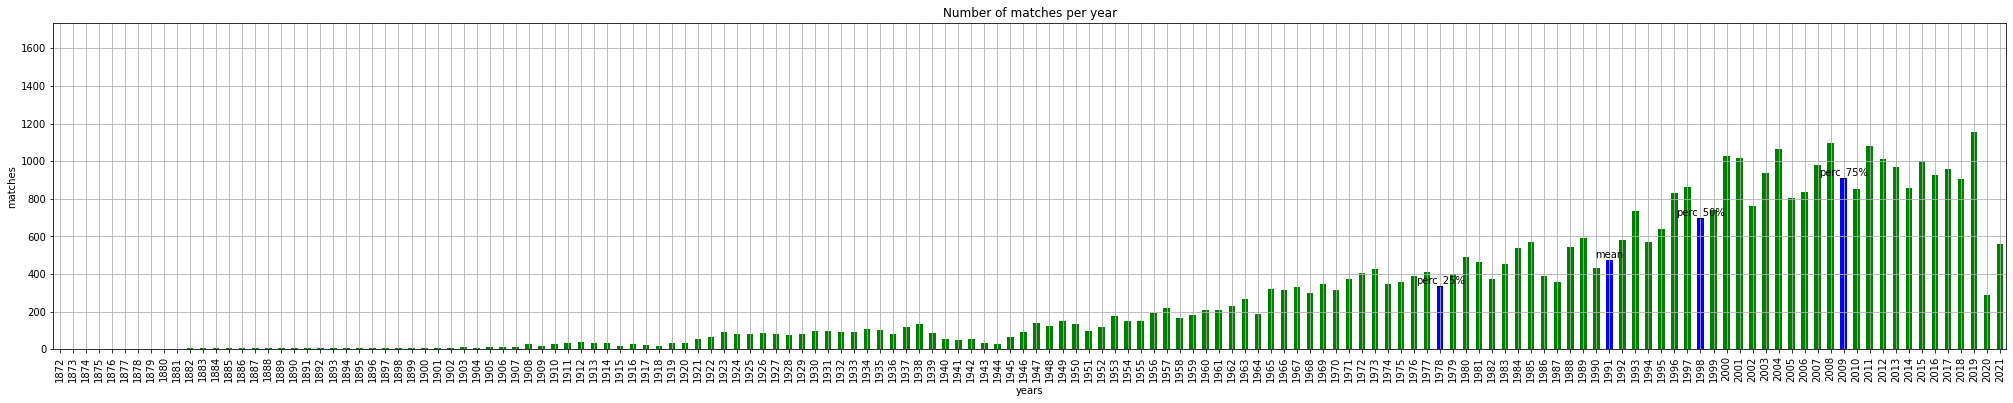

In [6]:
# number of matches per year
nmy = dst_df['year'].value_counts().sort_index()
colors = ['blue' if check_element(i, i_p.values) else 'green' for i in nmy.index]
lbls = [ add_labels(i, i_p_serie) if check_element(i, i_p.values) else '' for i in nmy.index]

plot_graph = nmy.plot(kind='bar', figsize=(35,6), title='Number of matches per year', xlabel='years', ylabel='matches', color=colors)
plot_graph.bar_label(container=plot_graph.containers[0], labels=lbls, label_type='edge')
plot_graph.margins(y=0.5)

plt.grid()
plt.show()

Inoltre controlliamo il mediano degli anni

In [4]:
dst_df['year'].median().astype(int)

1998

Che coincide col 50% percentile. Possiamo dunque splittare il dataset in due parti: calcio moderno e calcio 'vecchio'

In [20]:
old_era = pd.DataFrame(columns=dst_df.columns.drop(labels=['match_id', 'date']))
modern_era = old_era.copy()

for i in range(0, dst_df.__len__()):    
    if(dst_df.iloc[i]['year'] < dst_df['year'].median().astype(int)):
        old_era = old_era.append(dst_df.iloc[i].drop(labels=['date','match_id']))

    if(dst_df.iloc[i]['year'] >= dst_df['year'].median().astype(int)):
        modern_era = modern_era.append(dst_df.iloc[i])

old_era.to_csv('dataset/dataset_old_era.csv', index=False)
modern_era.to_csv('dataset/dataset_modern_era.csv', index=False)

if(old_era.__len__() + modern_era.__len__() == dst_df.__len__()):
    print("Dataset splitted successfully")
else:
    print("Something went wrong")

Dataset splitted successfully


## Todo ...